In [434]:
# Import libraries
import pandas as pd
import os
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

data_directory = 'data/'

In [435]:
# Taking all the data and putting it in a dictionary
data_files = dict()
for file in os.listdir(data_directory):
    f = os.path.join(data_directory, file)
    data = pd.read_csv(f, sep=';')
    sales_data = pd.DataFrame(data)
    data_files[file] = sales_data

In [436]:
# Analyse orders
data_files["products.csv"].head()

,product_id,product_name,supplier_id,category_id,quantity_per_unit,unit_price,units_in_stock,units_on_order,reorder_level,discontinued
0,1,Chai,8,1,10 boxes x 30 bags,18.00,39,0,10,1
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,1
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [437]:
data_files["order_details.csv"].head()

,order_id,product_id,unit_price,quantity,discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [438]:
data_files["orders.csv"].head()

,order_id,customer_id,employee_id,order_date,required_date,shipped_date,ship_via,freight,ship_name,ship_address,ship_city,ship_region,ship_postal_code,ship_country
0,10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,NaN,51100,France
1,10249,TOMSP,6,1996-07-05,1996-08-16,1996-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,NaN,44087,Germany
2,10250,HANAR,4,1996-07-08,1996-08-05,1996-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil
3,10251,VICTE,3,1996-07-08,1996-08-05,1996-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,NaN,69004,France
4,10252,SUPRD,4,1996-07-09,1996-08-06,1996-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,NaN,B-6000,Belgium


In [439]:
# Data
data_files['orders.csv']['order_date'] = pd.to_datetime(data_files['orders.csv']['order_date'])
data_files['orders.csv']['year_month'] = data_files['orders.csv']['order_date'].dt.to_period('M')


# Merging relevant data
order_details_relevant = data_files["order_details.csv"][['order_id', 'product_id', 'unit_price', 'quantity', 'discount']]
orders_relevant = data_files["orders.csv"][['order_id', 'freight', 'customer_id', 'year_month', 'ship_country']]
products_relevant = data_files["products.csv"][['product_id', 'product_name']]

sales_data = pd.merge(order_details_relevant, orders_relevant, on='order_id', how='inner')
sales_data = pd.merge(sales_data, products_relevant, left_on='product_id', right_on='product_id', how='inner')

# Sort by each order from customers
sales_data = sales_data.sort_values('order_id')
sales_data = sales_data.reset_index(drop=True)

# Remove last month since data looks incomplete
sales_data = sales_data.loc[sales_data['year_month'] != '1998-05']

# Detect changes in order_id and add True to the new_order column
sales_data['new_order'] = sales_data['order_id'] != sales_data['order_id'].shift()
# Fill the first row with True since there's no previous row to compare to
sales_data.loc[0, 'new_order'] = True

# Convert the values to boolean
sales_data['new_order'] = sales_data['new_order'].astype(bool)

sales_data.head(100)


,order_id,product_id,unit_price,quantity,discount,freight,customer_id,year_month,ship_country,product_name,new_order
0,10248,11,14.0,12,0.00,32.38,VINET,1996-07,France,Queso Cabrales,True
1,10248,72,34.8,5,0.00,32.38,VINET,1996-07,France,Mozzarella di Giovanni,False
2,10248,42,9.8,10,0.00,32.38,VINET,1996-07,France,Singaporean Hokkien Fried Mee,False
3,10249,14,18.6,9,0.00,11.61,TOMSP,1996-07,Germany,Tofu,True
4,10249,51,42.4,40,0.00,11.61,TOMSP,1996-07,Germany,Manjimup Dried Apples,False
...,...,...,...,...,...,...,...,...,...,...,...
95,10284,67,11.2,5,0.25,76.56,LEHMS,1996-08,Germany,Laughing Lumberjack Lager,True
96,10284,44,15.5,21,0.00,76.56,LEHMS,1996-08,Germany,Gula Malacca,False
97,10284,27,35.1,15,0.25,76.56,LEHMS,1996-08,Germany,Schoggi Schokolade,False
98,10284,60,27.2,20,0.25,76.56,LEHMS,1996-08,Germany,Camembert Pierrot,False


Average ticket: 1502.963143373494
Average Ticket per Month:


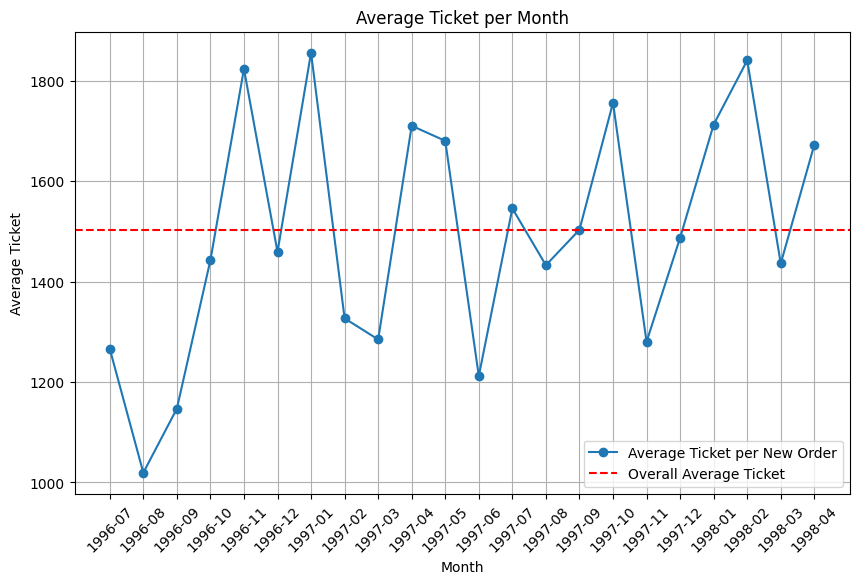

In [440]:
# Calculate medium ticket

sales_data['total_value'] = (sales_data['unit_price'] * (1-sales_data['discount'])) * sales_data['quantity']
average_ticket = sales_data['total_value'].sum() / len(data_files['orders.csv'])

print("Average ticket:", average_ticket)

# Group by year_month and calculate the total value for each month
monthly_ticket = sales_data.groupby('year_month')['total_value'].sum()

# Calculate the number of new orders for each month
new_orders_per_month = sales_data.groupby('year_month')['new_order'].sum()

# Calculate the average ticket per new order
average_ticket_per_new_order = monthly_ticket / new_orders_per_month

overall_average_ticket = sales_data['total_value'].sum() / len(data_files['orders.csv'])



print("Average Ticket per Month:")
""" print(average_ticket_per_month) """


plt.figure(figsize=(10, 6))
plt.plot(average_ticket_per_new_order.index.astype(str), average_ticket_per_new_order.values, marker='o', label='Average Ticket per New Order')
plt.axhline(y=overall_average_ticket, color='r', linestyle='--', label='Overall Average Ticket')
plt.xlabel('Month')
plt.ylabel('Average Ticket')
plt.title('Average Ticket per Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


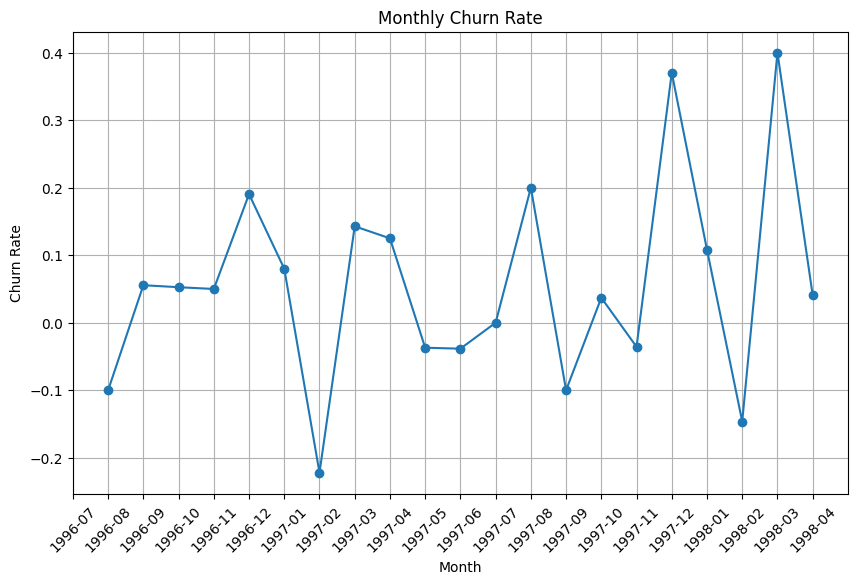

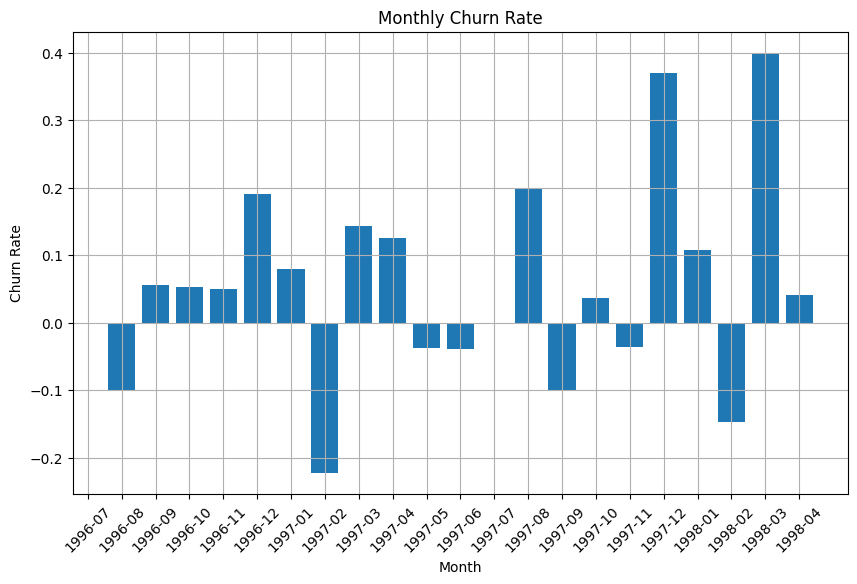

In [441]:
# Calculate Churn

unique_customers_per_month = sales_data.groupby('year_month')['customer_id'].nunique()

# Customers who purchased in the previous month but did not purchase in the current month
churned_customers_per_month = unique_customers_per_month.diff().fillna(0)

# Calculate the churn rate by dividing the number of customers who stopped buying by the total number of customers in the previous month.
churn_rate_per_month = churned_customers_per_month / unique_customers_per_month.shift()

# Plotar a taxa de churn mensal
plt.figure(figsize=(10, 6))
plt.plot(churn_rate_per_month.index.astype(str), churn_rate_per_month.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Churn Rate')
plt.title('Monthly Churn Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(churn_rate_per_month.index.astype(str), churn_rate_per_month.values)
plt.xlabel('Month')
plt.ylabel('Churn Rate')
plt.title('Monthly Churn Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


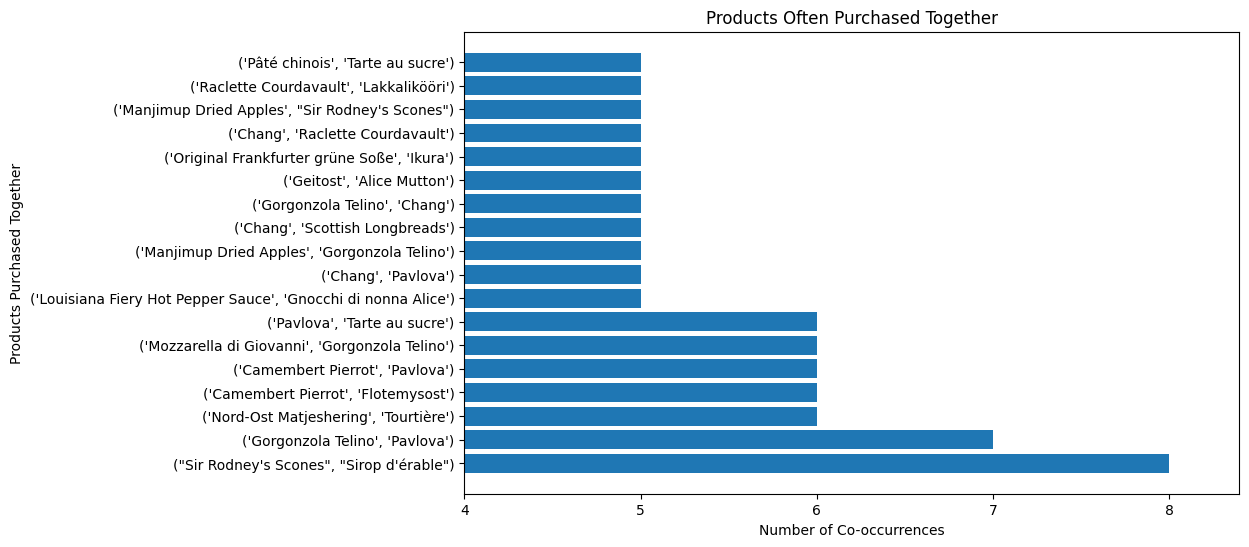

' clients = sales_data.groupby(\'year_month\')[\'customer_id\'].sum()\n\ndata_files["orders.csv"]["customer_id"].unique()\nprint(clients) '

In [442]:
'''One of the ways to increase the average ticket is to identify products that are frequently purchased together and suggest these products to customers as bundles. This can increase the total shopping cart value.'''

# Create a dictionary to store products purchased together
products_together = {}

# Group products by order
order_details = data_files['order_details.csv'][["order_id","product_id"]]

products_relevant = data_files["products.csv"][['product_id', 'product_name']]

items_sould = pd.merge(order_details, products_relevant, on='product_id', how='inner')

items_sould_grouped = items_sould.groupby("order_id")["product_name"].apply(list)

# Identify products frequently purchased together
for products in items_sould_grouped:
    pairs = list(combinations(products, 2))
    for pair in pairs:
        if pair in products_together:
            products_together[pair] += 1
        else:
            products_together[pair] = 1

products_together_df = pd.DataFrame(list(products_together.items()), columns=["products", "count"])

products_together_df = products_together_df.sort_values(by="count", ascending=False)
products_together_df = products_together_df.reset_index(drop=True)

# Show frequently bought products together
frequently_bought = products_together_df[products_together_df['count'] > 4]
""" print(frequently_bought) """

plt.figure(figsize=(10, 6))
plt.barh(frequently_bought["products"].apply(str), frequently_bought["count"])
plt.xlim(left=min(frequently_bought["count"]) - 1)
plt.xticks(range(min(frequently_bought["count"]) - 1, max(frequently_bought["count"]) + 1, 1))

plt.xlabel("Number of Co-occurrences")
plt.ylabel("Products Purchased Together")
plt.title("Products Often Purchased Together")
plt.show()

Average days to ship: 8.521739130434783


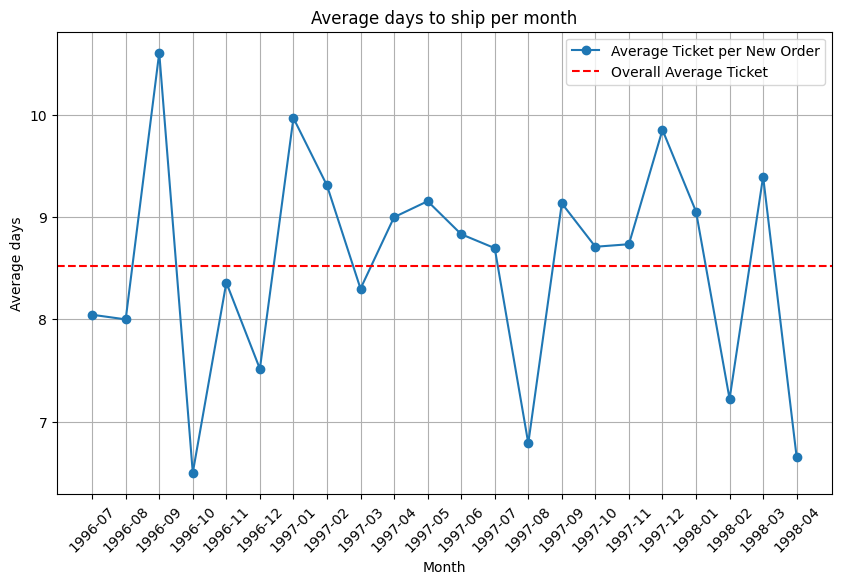

In [443]:
'''Average Order Processing Time:
Average difference between the "order_date" and "shipped_date" dates to measure how long, on average, it takes THE business to process and ship orders.'''

# Remove last month
data_files["orders.csv"] = data_files["orders.csv"].loc[data_files["orders.csv"]['year_month'] != '1998-05']

# Calculate day to ship per order and add on a column
data_files["orders.csv"]["days_to_ship"] = (pd.to_datetime(data_files["orders.csv"]["shipped_date"]) - pd.to_datetime(data_files["orders.csv"]["order_date"])).dt.days

# Group days to ship mean per month
monthly_days_to_ship = data_files["orders.csv"].groupby('year_month')['days_to_ship'].mean()

# Overall average days to ship
avg_days_to_ship = data_files["orders.csv"]["days_to_ship"].mean()


plt.figure(figsize=(10, 6))
plt.plot(monthly_days_to_ship.index.astype(str), monthly_days_to_ship.values, marker='o', label='Average Ticket per New Order')
plt.axhline(y=avg_days_to_ship, color='r', linestyle='--', label='Overall Average Ticket')
plt.xlabel('Month')
plt.ylabel('Average days')
plt.title('Average days to ship per month')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [444]:
data_files["products.csv"]["units_in_stock"] = pd.to_numeric(data_files["products.csv"]["units_in_stock"], errors="coerce")
data_files["products.csv"]["units_on_order"] = pd.to_numeric(data_files["products.csv"]["units_on_order"], errors="coerce")
# Calcular a média dos níveis de estoque considerando valores não nulos
data_files["products.csv"]["average_stock_level"] = data_files["products.csv"][["units_in_stock", "units_on_order"]].mean(axis=1, skipna=True)

# Remover linhas com valores ausentes antes de calcular a média
data_files["products.csv"] = data_files["products.csv"].dropna(subset=["average_stock_level"])

# Calcular a média dos níveis médios de estoque
avg_stock_level = data_files["products.csv"]["average_stock_level"].mean()

print("Average of average inventory levels:", avg_stock_level)

Average of average inventory levels: 25.318181818181817


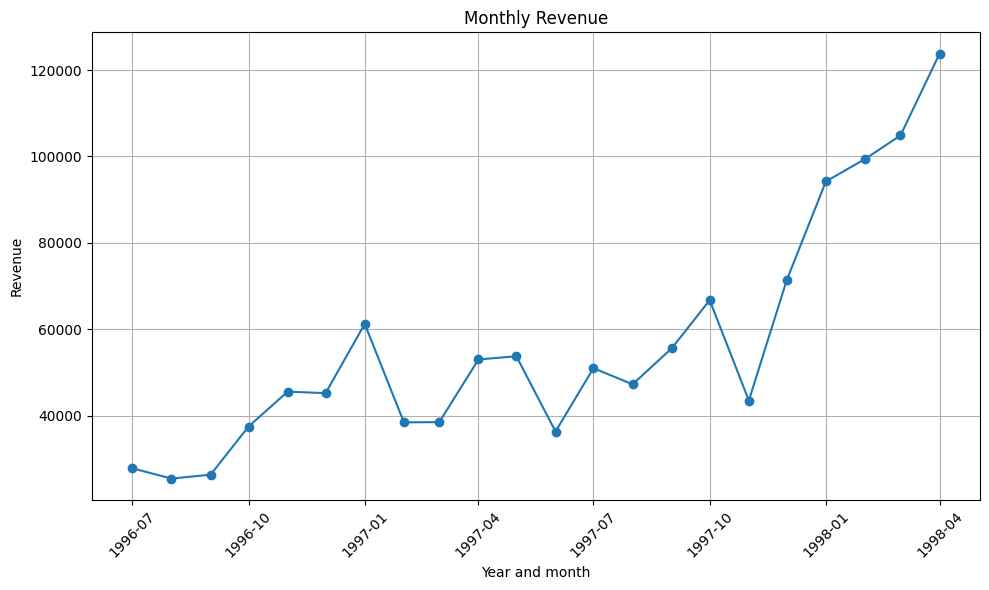

In [445]:
# Monthly billing over time
monthly_revenue = sales_data.groupby('year_month')['total_value'].sum()

monthly_revenue.index = pd.to_datetime(monthly_revenue.index.to_timestamp())

# Plot income over time
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o')
plt.title('Monthly Revenue')
plt.xlabel('Year and month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

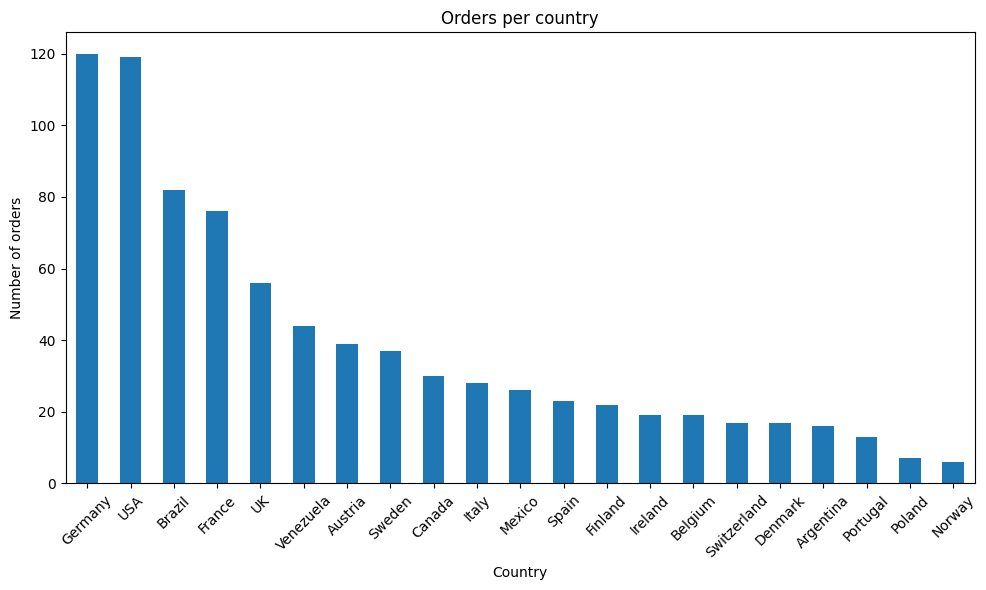

In [449]:
# Amount of orders per country
country_counts = data_files["orders.csv"]["ship_country"].value_counts()

# Bar graph
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar')
plt.title('Orders per country')
plt.xlabel('Country')
plt.ylabel('Number of orders')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

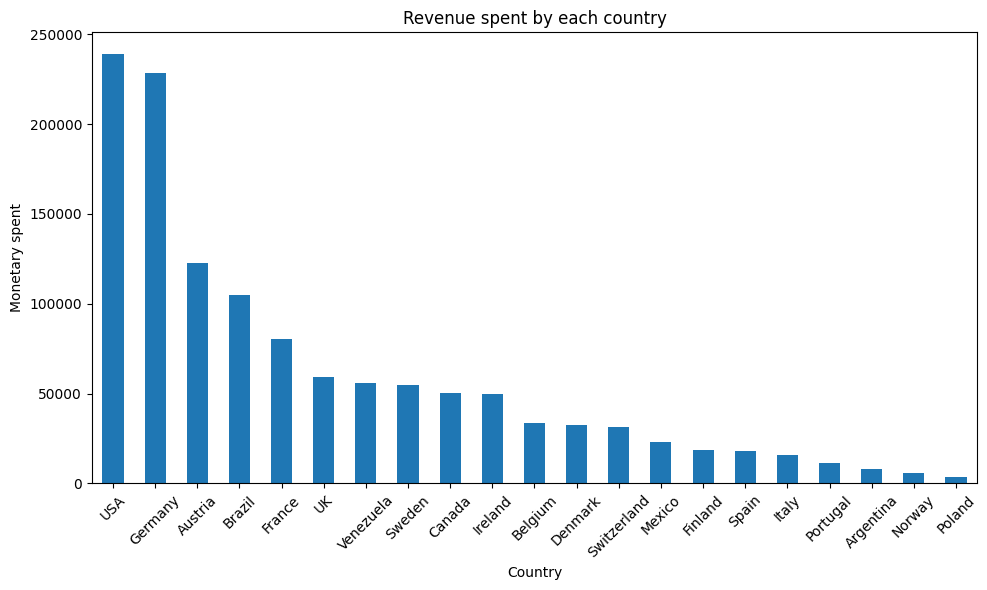

In [447]:
# Money spent on purchases by each country

country_revenue = sales_data.groupby('ship_country')['total_value'].sum()
country_revenue = country_revenue.sort_values(ascending=False)

# Bar graph
plt.figure(figsize=(10, 6))
country_revenue.plot(kind='bar')
plt.title('Revenue spent by each country')
plt.xlabel('Country')
plt.ylabel('Monetary spent')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

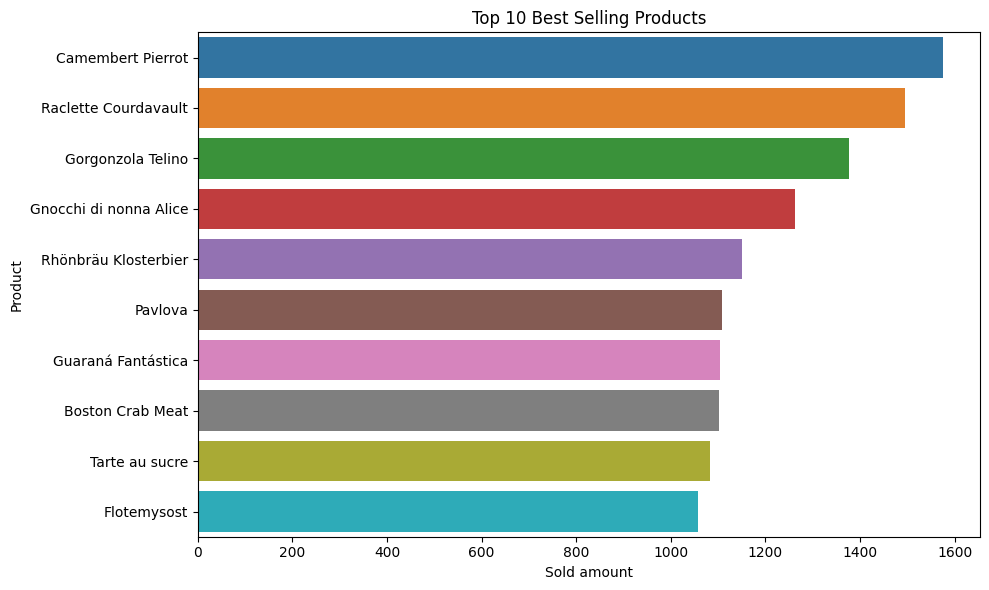

In [453]:
'''A strategy to increase the average ticket per customer consists of identifying the products that sell the most and thinking about how to present them together with less sold products.

That is, with this, less successful products can “piggyback” with the more profitable ones, generating a predictable income that guarantees the company's operations.'''

# Top 10 best selling products
top_products = sales_data.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)

# best selling products bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Best Selling Products')
plt.xlabel('Sold amount')
plt.ylabel('Product')
plt.tight_layout()
plt.show()